# Literature Genes Short List

Brian wants a short list for the literature genes.

In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import fisher_exact

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.config import read_config
from larval_gonad.scRNAseq import norm_data

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq-wf/scrnaseq_combine_force')

last updated: 2018-06-21 
Git hash: ee2f194108e3170c6c9864f32ee7350a3ccb5e71


In [38]:
# Figure out background
norm = norm_data(nbconfig.seurat_dir)
bg = norm.index[norm.sum(axis=1) > 1].tolist()

## Literature Genes

In [3]:
# Get a list of literature genes
cfg = read_config('../paper_submission/config.yaml')

lit_genes = cfg['lit_genes']
lit_fbgn = [nbconfig.symbol2fbgn[x] for x in lit_genes]

In [5]:
# Import Biomarkers
bm = nbconfig.seurat.get_biomarkers('res.0.6').query('p_val_adj < 0.001')

In [14]:
# Grab top 5 literature based markers by cluster
lit_bm = bm[bm.index.isin(lit_fbgn)]
subset_bm = lit_bm.sort_values(by=['cluster', 'avg_logFC']).groupby('cluster').head(5)
subset_bm = subset_bm[subset_bm.cluster.isin([6,3,2,0])].copy()
lit_subset = subset_bm.index.unique().tolist()
list(zip(lit_subset, [nbconfig.fbgn2symbol[x] for x in lit_subset]))

# Brian wants to make sure we add these
bo_genes = [
    'vas',
    'p53',
    'dj',
    'ocn',
    'bol',
    'can',
    'mia',
    'nht',
    'sa',
    'Taf12L',
    'aly',
    'fzo',
    'Mst87F',
    'tomb',
    'topi',
    'mip40',
    'Caf1-55',
    'mip130',
    'CycB',
]

# Make final list of literature genes
lit_subset = np.unique(lit_subset + [nbconfig.symbol2fbgn[x] for x in bo_genes]).tolist()

In [15]:
# for each cluster pull out the normalized counts literature genes
dfs = []
for c in range(12):
    norm = norm_data(nbconfig.seurat_dir, cluster=c)
    norm_subset = norm[norm.index.isin(lit_subset)].sum(axis=1)
    norm_subset.name = c
    dfs.append(norm_subset)

df = pd.concat(dfs, axis=1)
dfGene = df.copy()
dfGene.index = [nbconfig.fbgn2symbol[x] for x in dfGene.index]
dfGene.columns = [nbconfig.CLUSTER_ANNOT[x] for x in dfGene.columns]

In [17]:
# Organize genes for plot
go = [
    # Gonia
    'vas',
    'p53',
    'bam',
    'Rbp9',
    
    # Later spermatocytes
    ## tTAFs
    'can',
    'nht',
    'sa',
    'Taf12L',
    'mia',
    
    # tMAC
    'Caf1-55',
    'mip130',
    'aly',
    'tomb',
    'topi',
    'mip40',
    
    # terminal differentiation genes
    'fzo',
    'Mst87F',
    'dj',
    'ocn',
    
    # required for meiosis I
    'twe',
    'bol',
    'CycB',
    
    # Important for spermatid
    'soti',
    'sowi',
    'c-cup',
    'wa-cup',
    'd-cup',
    'oys',
    
]

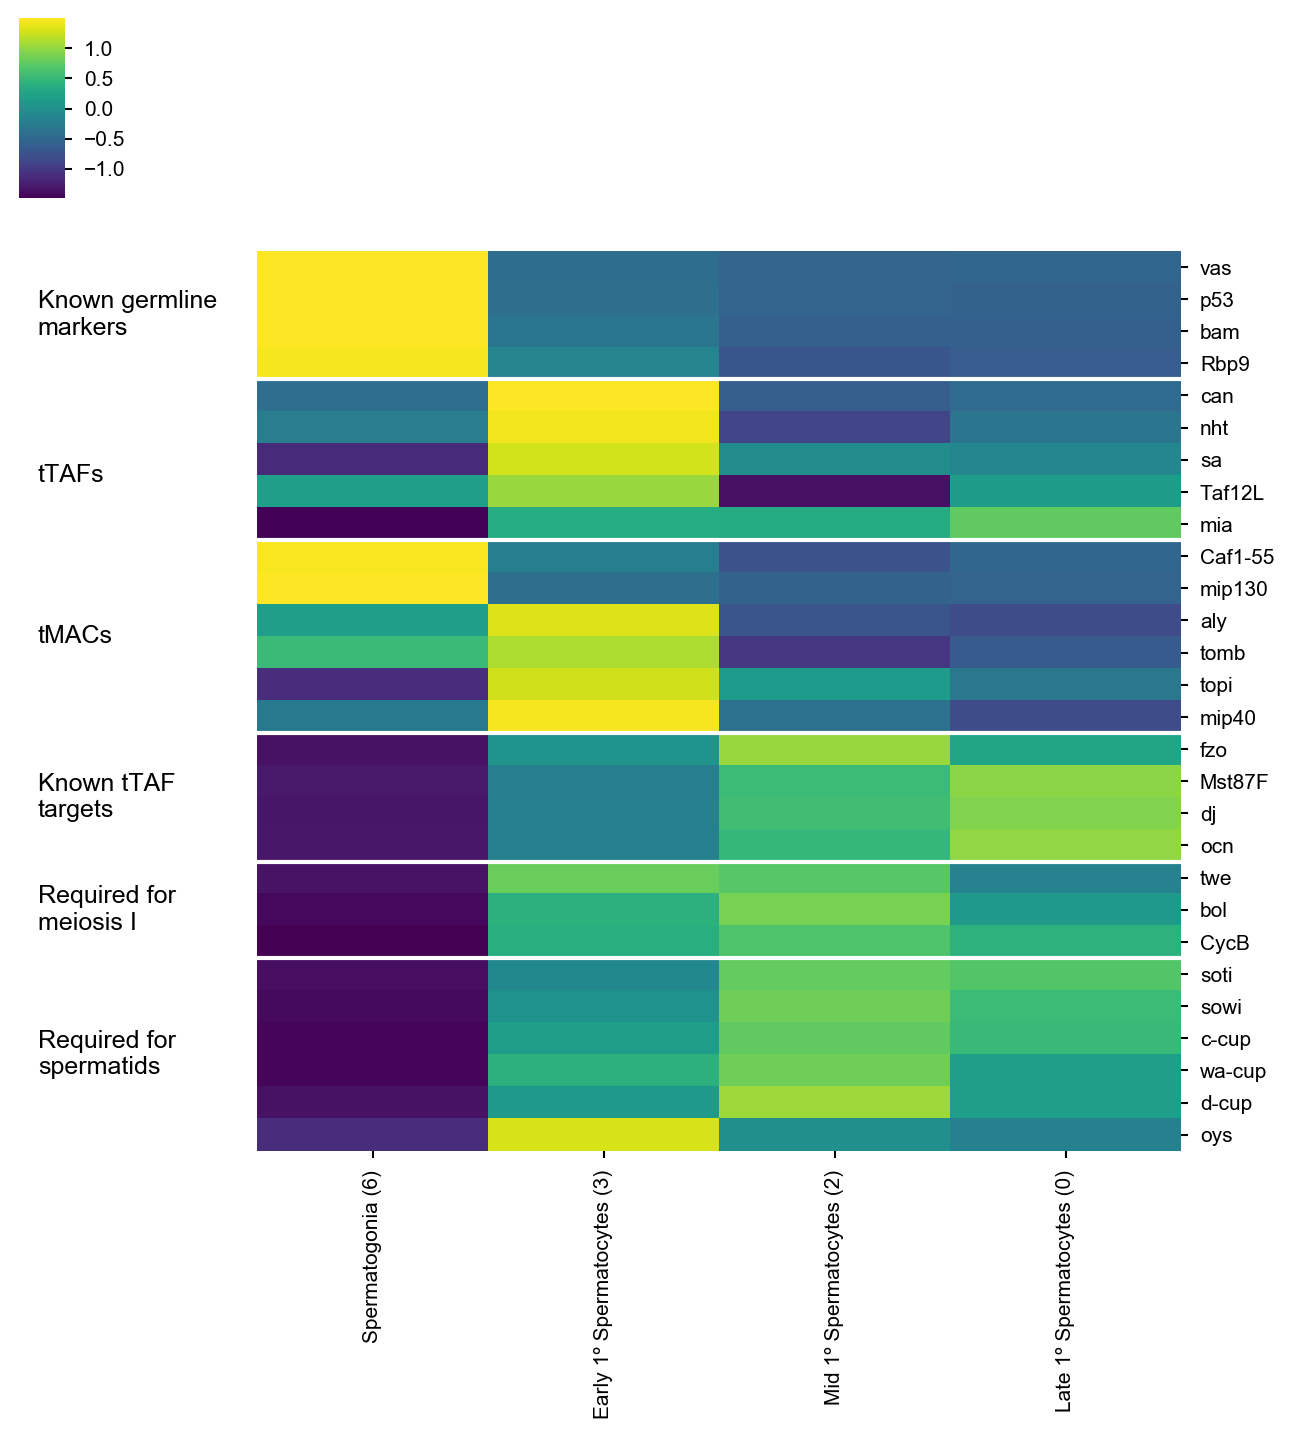

In [18]:
# Plot literature genes
g = sns.clustermap(dfGene.loc[go, nbconfig.CLUSTER_ORDER[:4]], 
                   cmap='viridis', z_score='row', 
                   row_cluster=False, col_cluster=False)

ax = g.ax_heatmap

ax.axhline(4, color='w', lw=2)
ax.axhline(9, color='w', lw=2)
ax.axhline(15, color='w', lw=2)
ax.axhline(19, color='w', lw=2)
ax.axhline(22, color='w', lw=2)

ax.text(-.95, 2, 'Known germline\nmarkers', va='center', fontsize=12)
ax.text(-.95, 7, 'tTAFs', va='center', fontsize=12)
ax.text(-.95, 12, 'tMACs', va='center', fontsize=12)
ax.text(-.95, 17, 'Known tTAF\ntargets', va='center', fontsize=12)
ax.text(-.95, 20.5, 'Required for\nmeiosis I', va='center', fontsize=12)
ax.text(-.95, 25, 'Required for\nspermatids', va='center', fontsize=12)

g.savefig('../output/figures/2018-06-21_lit_genes.pdf')

## X To A

In [56]:
dfs = []
for c in [0, 2, 3, 6]:
    _df = norm_data(nbconfig.seurat_dir, cluster=c).sum(axis=1)
    _df.name = c
    dfs.append(_df)
    
norm = pd.concat(dfs, axis=1)

In [57]:
def get_sig(fname):
    diff = pd.read_csv(fname, sep='\t', index_col=[0, 1])
    diff.index.names = ['FBgn', 'gene']
    return diff.query('p_val_adj <= 0.001').sort_values(by='avg_logFC')

def get_bias(dat=None, fname=None, direction='down'):
    if direction == 'down':
        query = 'avg_logFC < -1'
    elif direction == 'up':
        query = 'avg_logFC > 1'
    else:
        raise ValueError("Only down | up are valid direction values.")
        
    if dat is not None:
        return dat.query(query).index.get_level_values(0).tolist()
    
    if fname is not None:
        dat = get_sig(fname)
        return get_bias(dat, direction=direction)
    
    raise ValueError("You must provide data for a filename")

In [58]:
sp1 = set(get_bias(fname='../output/2018-06-21_scrnaseq_spermatogonia_vs_early_biomarkers.tsv', direction='down'))
sp2 = set(get_bias(fname='../output/2018-06-21_scrnaseq_spermatogonia_vs_mid_biomarkers.tsv', direction='down'))
sp3 = set(get_bias(fname='../output/2018-06-21_scrnaseq_spermatogonia_vs_late_biomarkers.tsv', direction='down'))

cyte_bias = sp1.intersection(sp2).intersection(sp3)

In [59]:
sp1 = set(get_bias(fname='../output/2018-06-21_scrnaseq_spermatogonia_vs_early_biomarkers.tsv', direction='up'))
sp2 = set(get_bias(fname='../output/2018-06-21_scrnaseq_spermatogonia_vs_mid_biomarkers.tsv', direction='up'))
sp3 = set(get_bias(fname='../output/2018-06-21_scrnaseq_spermatogonia_vs_late_biomarkers.tsv', direction='up'))

sp_bias = sp1.intersection(sp2).intersection(sp3)

In [60]:
len(sp_bias), len(cyte_bias)

(116, 188)

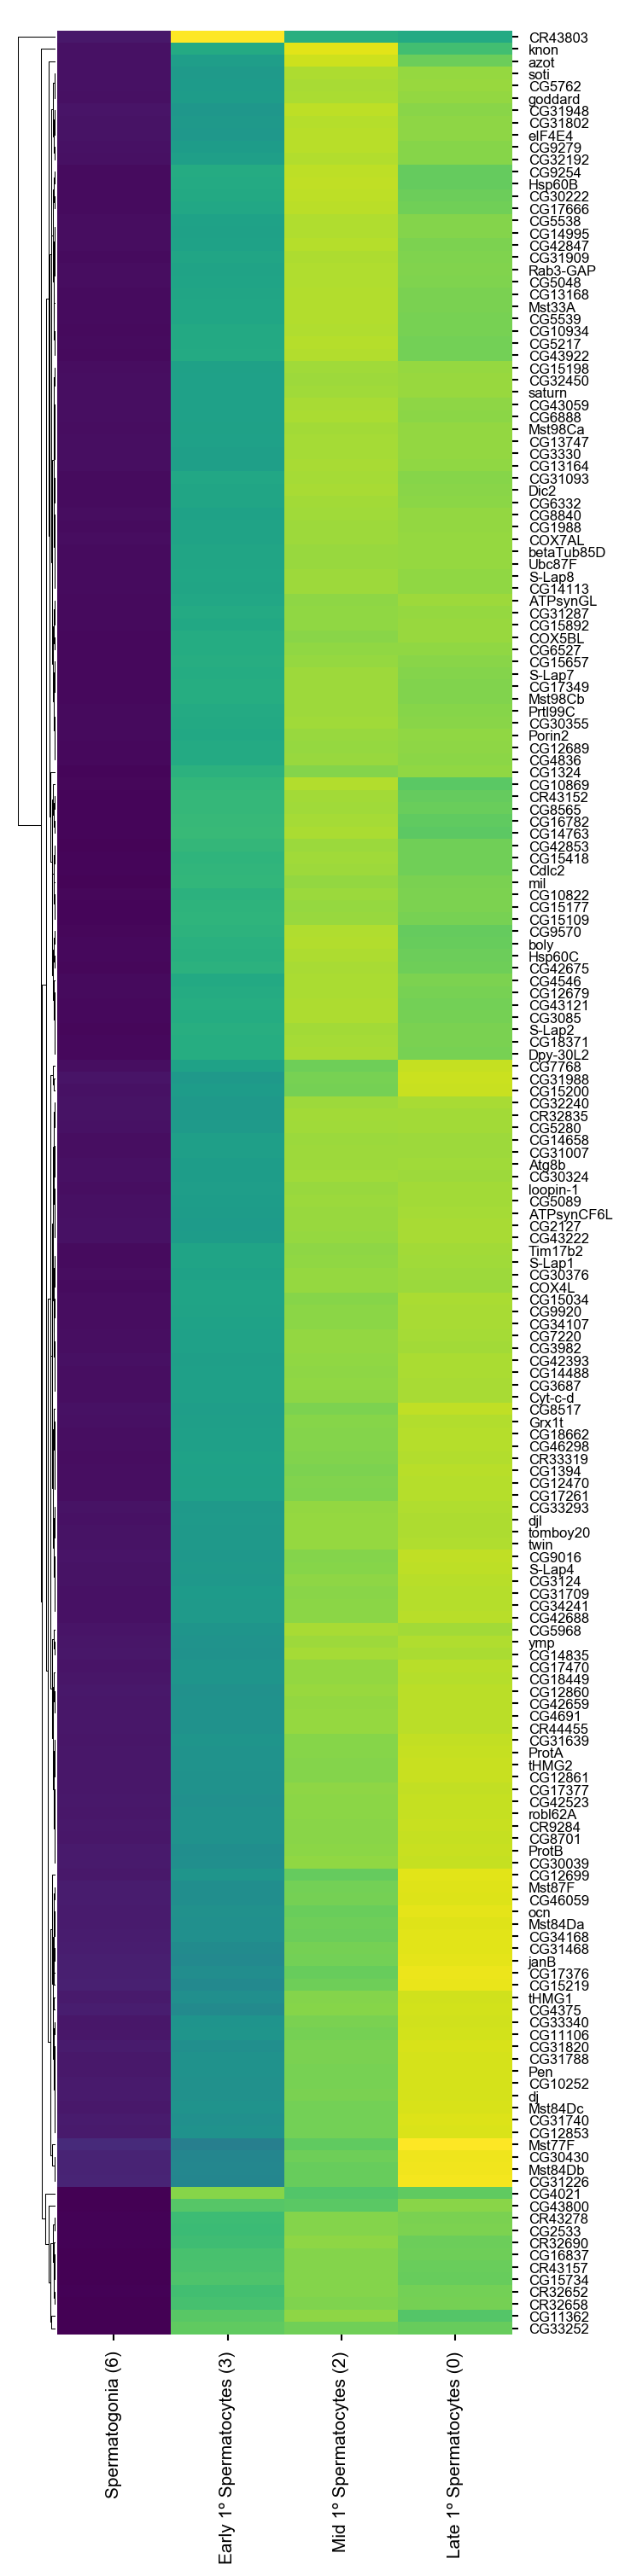

In [61]:
dat = norm[norm.index.isin(cyte_bias)]
dat.columns = [nbconfig.CLUSTER_ANNOT[x] for x in dat.columns]
dat.index = [nbconfig.fbgn2symbol[x] for x in dat.index]
g = sns.clustermap(dat[nbconfig.CLUSTER_ORDER[:4]], 
                   z_score=0, 
                   cmap='viridis', 
                   yticklabels=True, 
                   col_cluster=False, 
                   figsize=(5, 30))
ax = g.ax_heatmap
plt.setp(ax.get_yticklabels(), fontsize=8);

g.cax.set_visible(False)
col = g.ax_col_dendrogram.get_position()
g.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height*0.01])
g.savefig('../output/figures/2018-06-21_cyte_biased.pdf')

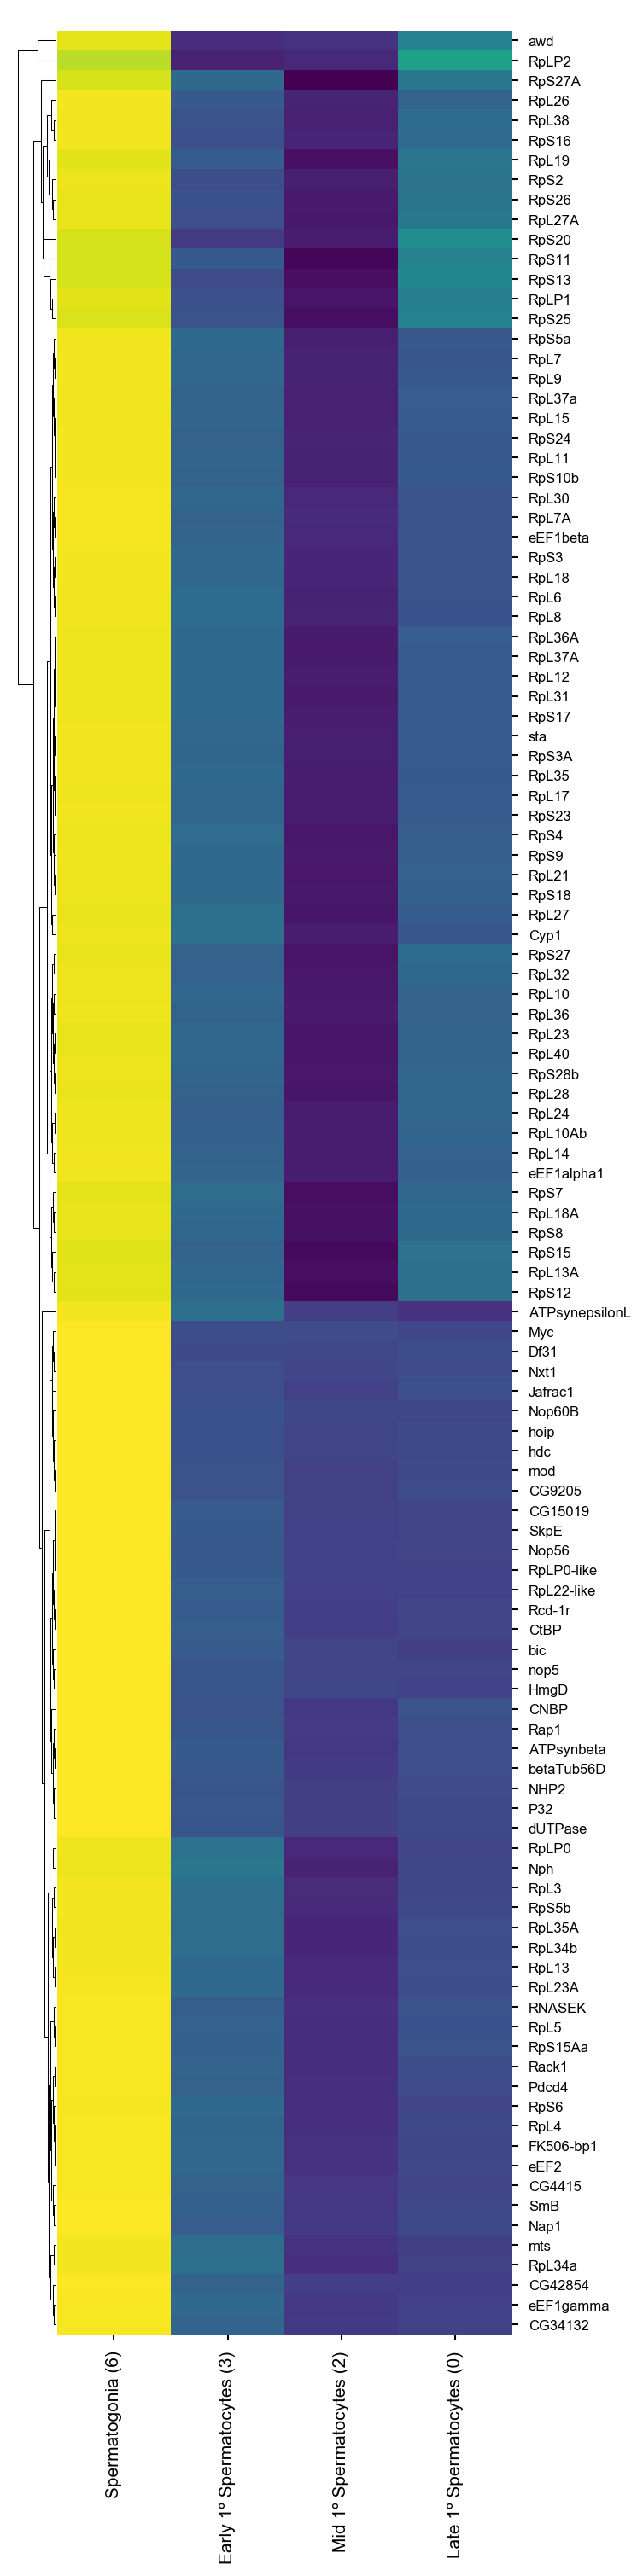

In [62]:
dat = norm[norm.index.isin(sp_bias)]
dat.columns = [nbconfig.CLUSTER_ANNOT[x] for x in dat.columns]
dat.index = [nbconfig.fbgn2symbol[x] for x in dat.index]
g = sns.clustermap(dat[nbconfig.CLUSTER_ORDER[:4]], 
                   z_score=0, 
                   cmap='viridis', 
                   yticklabels=True, 
                   col_cluster=False, 
                   figsize=(5, 30))
ax = g.ax_heatmap
plt.setp(ax.get_yticklabels(), fontsize=8);

g.cax.set_visible(False)
col = g.ax_col_dendrogram.get_position()
g.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height*0.01])
g.savefig('../output/figures/2018-06-21_gonia_biased.pdf')

In [63]:
chrom = nbconfig.fbgn2chrom[nbconfig.fbgn2chrom.index.isin(bg)].copy()
chrom.chrom.value_counts()

chr3R    3405
chr3L    2825
chr2R    2818
chr2L    2729
chrX     2155
chr4       99
chrY       42
chrM       18
Name: chrom, dtype: int64

In [64]:
chrom['gonia'] = False
chrom.loc[chrom.index.isin(sp_bias), 'gonia'] = True

chrom['cyte'] = False
chrom.loc[chrom.index.isin(cyte_bias), 'cyte'] = True

In [65]:
[nbconfig.fbgn2symbol[x] for x in chrom[chrom.gonia & (chrom.chrom == 'chrX')].index.tolist()]

['RpL36',
 'sta',
 'RpL35',
 'RpL7A',
 'RpL17',
 'RpS28b',
 'RpS6',
 'CG42854',
 'Myc',
 'RpS10b',
 'Jafrac1',
 'RpS15Aa',
 'Pdcd4',
 'RpL37a',
 'Cyp1',
 'RpS5a',
 'SkpE']

In [66]:
[nbconfig.fbgn2symbol[x] for x in chrom[chrom.cyte & (chrom.chrom == 'chrX')].index.tolist()]

['CG9570',
 'CG12470',
 'CG16782',
 'CG15034',
 'CG12689',
 'CR32690',
 'CG15892',
 'CR32652',
 'CR43152',
 'CR43157',
 'CR43278',
 'CG15200',
 'CG11106',
 'CG15198',
 'CG1394',
 'CG2533',
 'CR32658',
 'CG15734',
 'CG8565',
 'CG33252',
 'CG1324',
 'CG12679']

In [67]:
gonia_ct = pd.crosstab(chrom.chrom, chrom.gonia)
gonia_test = pd.concat([gonia_ct.loc[['chr2L', 'chr2R', 'chr3L', 'chr3R']].sum(), gonia_ct.loc['chrX']], axis=1)
gonia_test.columns = ['Autosome', 'X']
gonia_test

,Autosome,X
gonia,,
False,11680,2138
True,97,17


In [68]:
fisher_exact(gonia_test)

(0.95744167880184772, 1.0)

In [69]:
cyte_ct = pd.crosstab(chrom.chrom, chrom.cyte)
cyte_test = pd.concat([cyte_ct.loc[['chr2L', 'chr2R', 'chr3L', 'chr3R']].sum(), cyte_ct.loc['chrX']], axis=1)
cyte_test.columns = ['Autosome', 'X']
cyte_test

,Autosome,X
cyte,,
False,11611,2133
True,166,22


In [60]:
fisher_exact(cyte_test)

(0.73079321441413558, 0.18573138272810552)

In [70]:
crs = []
for fb in chrom.index:
    try:
        gene = nbconfig.fbgn2symbol[fb]
        if gene.startswith('CR'):
            crs.append(fb)
    except:
        pass

In [71]:
mask = ~chrom.index.isin(crs)

In [72]:
gonia_ct = pd.crosstab(chrom[mask].chrom, chrom[mask].gonia)
gonia_test = pd.concat([gonia_ct.loc[['chr2L', 'chr2R', 'chr3L', 'chr3R']].sum(), gonia_ct.loc['chrX']], axis=1)
gonia_test.columns = ['Autosome', 'X']
gonia_test

,Autosome,X
gonia,,
False,10100,1916
True,97,17


In [73]:
fisher_exact(gonia_test)

(0.92385338871790457, 0.89763398686034646)

In [74]:
cyte_ct = pd.crosstab(chrom[mask].chrom, chrom[mask].cyte)
cyte_test = pd.concat([cyte_ct.loc[['chr2L', 'chr2R', 'chr3L', 'chr3R']].sum(), cyte_ct.loc['chrX']], axis=1)
cyte_test.columns = ['Autosome', 'X']
cyte_test

,Autosome,X
cyte,,
False,10036,1917
True,161,16


In [75]:
fisher_exact(cyte_test)

(0.52027462682698444, 0.0094882606667714801)

## X To A biomarkers

In [76]:
germ_marks = bm[bm.cluster.isin([6, 0, 2, 3])]

In [77]:
germ_marks.head()

,gene_symbol,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster
FBgn,,,,,,,
FBgn0000028,acj6,1.025724e-242,0.272321,0.342,0.066,1.484838e-238,3
FBgn0000046,Act87E,2.106457e-106,0.398019,0.353,0.141,3.049307e-102,2
FBgn0000064,Ald,5.084456e-77,0.403284,0.737,0.595,7.360259e-73,2
FBgn0000100,RpLP0,0.000000e+00,0.989119,0.969,0.746,0.000000e+00,6
FBgn0000114,bru1,1.148937e-33,0.760529,0.391,0.329,1.663201e-29,0


In [89]:
num_germ = germ_marks.join(nbconfig.fbgn2chrom).groupby(['cluster', 'chrom']).size().to_frame().unstack(level=0)
num_germ.columns = num_germ.columns.droplevel(0)
num_germ = num_germ.loc[['chrX', 'chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4', 'chrY']].copy()
num_germ.fillna(0, inplace=True)

In [92]:
tot = num_germ.sum()

In [101]:
pct_germ = (num_germ / tot * 100)
pct_germ.columns = [nbconfig.CLUSTER_ANNOT[x] for x in pct_germ.columns]
pct_germ = pct_germ[nbconfig.CLUSTER_ORDER[:4]].copy()

In [103]:
pct_germ.to_clipboard()